# **Final project IDS 2020/2021**

### Title:
> Analysis and visualization of the earthquakes that occurred from 1965 to 2016

### Group:
> * Christian Stingone https://github.com/ChriStingo
> * Alex Di Stefano https://github.com/xDiste

# **Context and motivations**

### Dataset
> The dataset we use relates to earthquakes globally. The data are recorded from 1965 to 2016
>
> Source link: https://www.kaggle.com/usgs/earthquake-database/code

### Type of analysis:
> Reporting, visualization and prediction

### Purpose
> The purpose of this project is to extrapolate information relating to earthquakes given the dataset, to allow a useful and pleasant visualization and to make a prediction.

## **Install libraries and import**

The installation of these libraries may take several seconds, please wait and run this cell only once per runtime.

Disregard the output of this cell.

In [ ]:
!pip install wordcloud
!pip install geopandas
!pip install reverse_geocoder
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pycountry-convert

We carry out all the necessary imports

In [29]:
#Import
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud 
import math
import datetime # for the .to_datetime function
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import reverse_geocoder as rg # to add column of state
import pycountry_convert as pc
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import warnings
warnings.filterwarnings("ignore") 

## **Reading and standardization of the dataset**

Let's read the dataset by importing it as a local file. We delete the columns that do not interest us and standardize the remaining columns.


* We make the column relating to the date of type "datetime"
* The column relating to the magnitude we approximate it to a decimal figure
* Insert the column relating to the country where the earthquake occurred. This data is provided to us by the reverse_geocoder library taking latitude and longitude as input. The output is in iso alpha 2, i.e. each state is represented by 2 letters.

We proceed to print the dataset to give an idea of the stored data.

In [30]:
# Let's read the CSV
url = 'earthquake.csv'
df = pd.read_csv(url, error_bad_lines=False)

# Delete the columns that do not interest us
df = df.drop(columns=['Depth Error', 'Depth Seismic Stations', 'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID', 'Location Source', 'Magnitude Source', 'Status'])

# Standardize the dataset
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.date
df['Magnitude'] = df['Magnitude'].round(1)

# Let's add the status column
coords = tuple(zip(df['Latitude'], df['Longitude']))
results_rg = rg.search(coords)
nations = [x.get('cc') for x in results_rg]     # iso alpha2
df['Nation'] = nations

# Print the dataframe obtained
df

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Source,Nation
0,1965-01-02,13:44:18,19.2460,145.6160,Earthquake,131.60,6.0,MW,ISCGEM,MP
1,1965-01-04,11:29:49,1.8630,127.3520,Earthquake,80.00,5.8,MW,ISCGEM,ID
2,1965-01-05,18:05:58,-20.5790,-173.9720,Earthquake,20.00,6.2,MW,ISCGEM,TO
3,1965-01-08,18:49:43,-59.0760,-23.5570,Earthquake,15.00,5.8,MW,ISCGEM,GS
4,1965-01-09,13:32:50,11.9380,126.4270,Earthquake,15.00,5.8,MW,ISCGEM,PH
...,...,...,...,...,...,...,...,...,...,...
23407,2016-12-28,08:22:12,38.3917,-118.8941,Earthquake,12.30,5.6,ML,NN,US
23408,2016-12-28,09:13:47,38.3777,-118.8957,Earthquake,8.80,5.5,ML,NN,US
23409,2016-12-28,12:38:51,36.9179,140.4262,Earthquake,10.00,5.9,MWW,US,JP
23410,2016-12-29,22:30:19,-9.0283,118.6639,Earthquake,79.00,6.3,MWW,US,ID


## **Types of recorded events**

Not all recorded events are earthquakes, some are man-made and some natural, what matters is that each of these events caused the propagation of seismic waves.

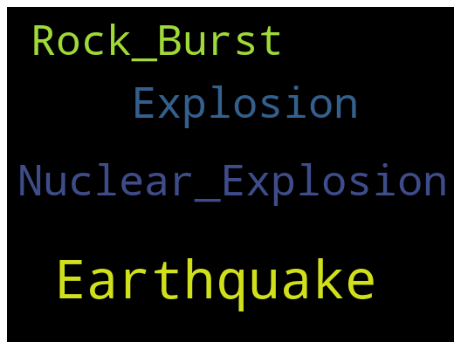


Number of events by type


,Type,Number of events
0,Earthquake,23232
1,Explosion,4
2,Nuclear Explosion,175
3,Rock Burst,1


In [31]:
types = []
for x in df['Type'].unique():
    types.append(x.replace(' ', '_'))

wordcloud = WordCloud(
                          background_color='black',
                          width=512,
                          height=384
                         ).generate(" ".join(types))
plt.figure(figsize=(8,8))

plt.imshow(wordcloud)
plt.axis('off')
plt.margins(x = 0, y = 0)
plt.show()

print("\nNumber of events by type")
df_type = df.groupby("Type")['Type'].size().reset_index(name='Number of events')
df_type



> An interesting fact that we can see from the execution of this cell is that the earthquakes caused by nuclear explosions are many, this should lead us to further reflect on the extreme power released by these weapons.


## **Earthquakes globally**

We want to analyze earthquake data on a global scale.

We begin by checking the frequency of the magnitude in reference to each earthquake present in the dataset.

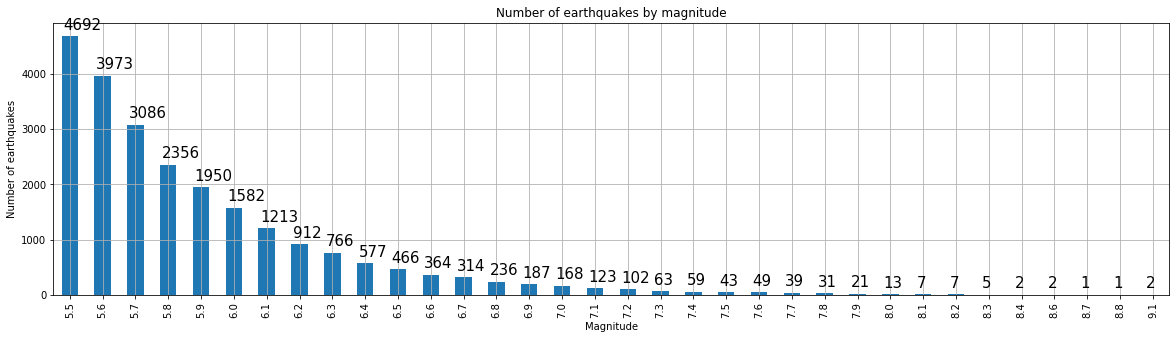

In [32]:
# Graph of the magnitude
# We group by magnitude by counting the number of earthquakes
df_mag = df.groupby("Magnitude")['Magnitude'].size().reset_index(name='counts')
ax = df_mag.plot.bar(x='Magnitude', y='counts', figsize=(20, 5), legend=None)
plt.grid()
plt.title("Number of earthquakes by magnitude")
plt.ylabel("Number of earthquakes")
for v, i in enumerate(df_mag['counts']):
    ax.text(v-0.2, i+200, ""+str(df_mag['counts'][v]), va='center', fontsize=15)



> This graph allows us to see that earthquakes with a low magnitude are much more likely than those with a higher intensity. We also note that no earthquakes of magnitude 8.9 or 9.0 are recorded, while we can notice earthquakes of 9.1 power. This is caused by the interval the dataset is working on. We can observe that the curve decreases exponentially confirming the fact that the Richter scale was designed in logarithmic scale.



In this cell we want to see where all the earthquakes in the dataset occurred.

Text(0.5, 1.0, 'Earthquakes around the world')

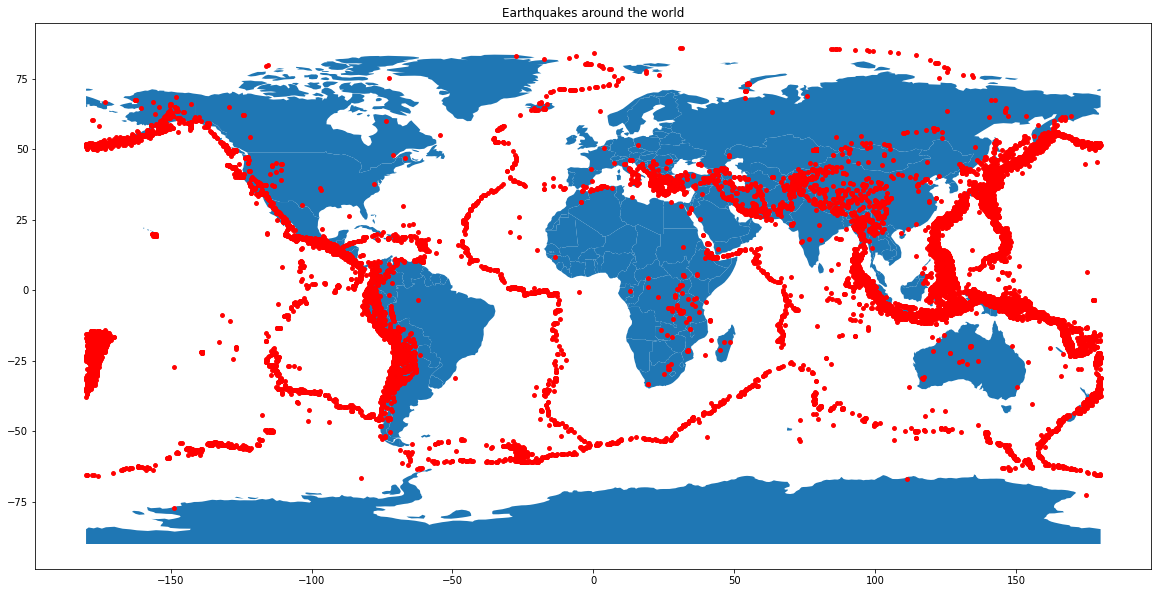

In [34]:
# Total distribution of earthquakes and identification of seismic areas
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

# Graphic
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(20, 15)), marker='o', color='red', markersize=15)
ax.set_title("Earthquakes around the world")



> This graph allows us not only to know the location of each earthquake, but also gives us a clear idea of what and where the various tectonic plates that make up the earth's crust are. This is possible as we know that when two plates collide they cause an earthquake. We also note that at the point where there are more earthquakes, that is around Indonesia, it is also the point where there are more different tectonic plates, causing continuous clashes and earthquakes.


We now ask ourselves what power the earthquakes we have just visualized are and possibly what state they belong to. Since there are many states and most earthquakes occur in the sea, we decided to color each circle with a different color for each geographical area (obviously this causes color repetitions). Furthermore, the larger the radius of a circle is, the more powerful is the earthquake to which it refers.

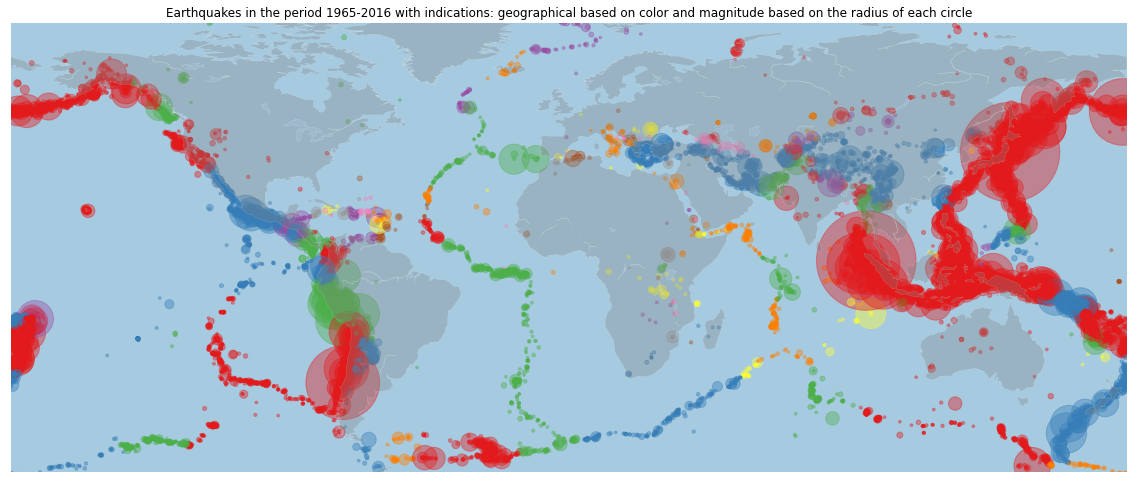

In [35]:
#Chart setup
plt.rcParams["figure.figsize"]=20,15; 
plt.title("Earthquakes in the period 1965-2016 with indications: geographical based on color and magnitude based on the radius of each circle")
m=Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

# We prepare the circles relative to the magnitude
data = pd.factorize(df['Nation'])[0]
s=[]
for i in range(len(df)):
    s.append(math.exp(df['Magnitude'][i]-4.5)**2)

# Let's add earthquakes
m.scatter(
    x=df['Longitude'], 
    y=df['Latitude'], 
    s=s, 
    alpha=0.4, 
    c=data, 
    cmap="Set1"
)

This graph gives us an idea on a geographical level, but does not express precisely the state of belonging of an earthquake. This is what we want to achieve with the cell below.

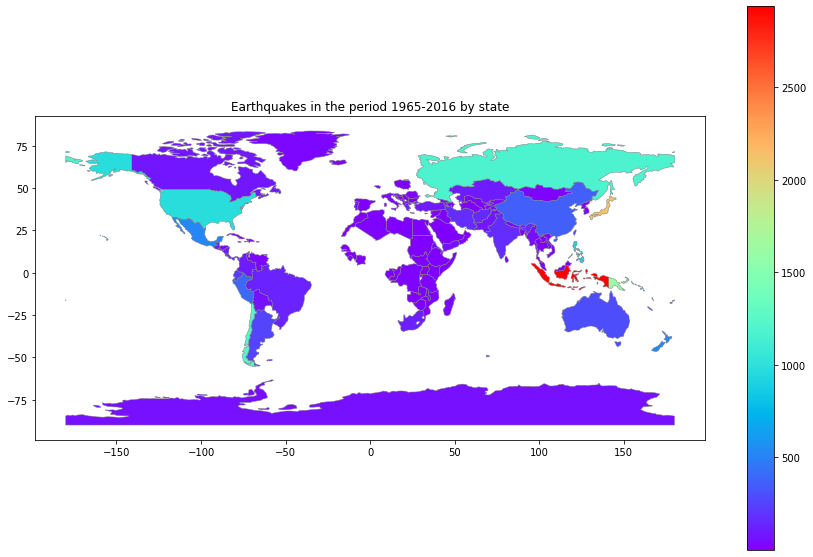

In [36]:
# Number of earthquakes by state

# Group by nation alpha 2
df_tmp = df.groupby('Nation')['Nation'].count().reset_index(name='counts')

# Convert iso alpha 2 -> iso alpha 3
for i in range(len(df_tmp)):    
    if df_tmp['Nation'][i] == 'XK':     # Kosovo not present in geopandas, identified as Serbia
        # Add Serbia (already calculated because RS <XK) the earthquakes in Kosovo
        df_tmp['counts'][df_tmp.index[df_tmp['Nation'] == 'SRB']] += df_tmp['counts'][i]    
    else:
        # I replace alpha 2 values in alpha 3
        df_tmp['Nation'].replace(df_tmp['Nation'][i], (pd.Series([pc.country_name_to_country_alpha3(pc.country_alpha2_to_country_name(df_tmp['Nation'][i]))]))[0], inplace=True)

# Merge with the geopandas dataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(df_tmp, left_on='iso_a3', right_on='Nation', how='left').dropna(axis=0).reset_index()

# Graphic
world.plot(column='counts', cmap='rainbow', legend=True, linewidth=0.5, edgecolor='0.5', figsize=(15, 10))
plt.title("Earthquakes in the period 1965-2016 by state")
plt.show()

> Thanks to this visualization we can see that the states most affected by earthquakes are Indonesia and Japan, which are far apart from the other states. Fortunately, we can note that the geographical area relating to Europe and, therefore, also to Italy is little affected by these events. The least seismic continents are Africa and Europe, which have states where earthquakes have never occurred.

## **Time data**

We now want to have temporal information on earthquakes.

We wonder how many and where earthquakes occurred in each year recorded in our dataset.

In [37]:
fig = px.density_mapbox(
                        df, lat=df['Latitude'], lon=df['Longitude'], z=df['Magnitude'],
                        mapbox_style="satellite-streets",
                        zoom=1.3, radius = 13, width = 1500, height = 900, center=dict(lat=30, lon=15),
                        animation_frame=pd.DatetimeIndex(df['Date']).year,
                        range_color=(1,10),
                        color_continuous_scale=px.colors.sequential.Jet_r
                        )
fig.update_layout(title_text='Annual earthquake map', title_font=dict(size=32), mapbox_accesstoken = "pk.eyJ1IjoiY2Fzc2FwYW5jYTk5IiwiYSI6ImNrcHlrZ3hubjA3NHMycW84ZnFhcTFnYzgifQ.HscwNQouRsZW52ELwpuR_A")

fig.show()

> Thanks to this animated display it is possible to see which, where and of what magnitude the earthquakes occurred over time.
>
> This visualization corresponds to a heat map, which allows us to assign a color scale relating to the power of an earthquake, but this marks even the smallest earthquake agglomerations as very powerful earthquakes, not allowing to color individual earthquakes appropriately. This is noticeable by zooming in on the map and hovering the mouse over the points. This will open a legend containing information such as Year, Magnitude, Latitude and Longitude.

We now ask what is the distribution of earthquakes by year, month, day and time. Let's try to note if there are data useful for forecasting the times of the year in which it is more likely the occurrence of these events.

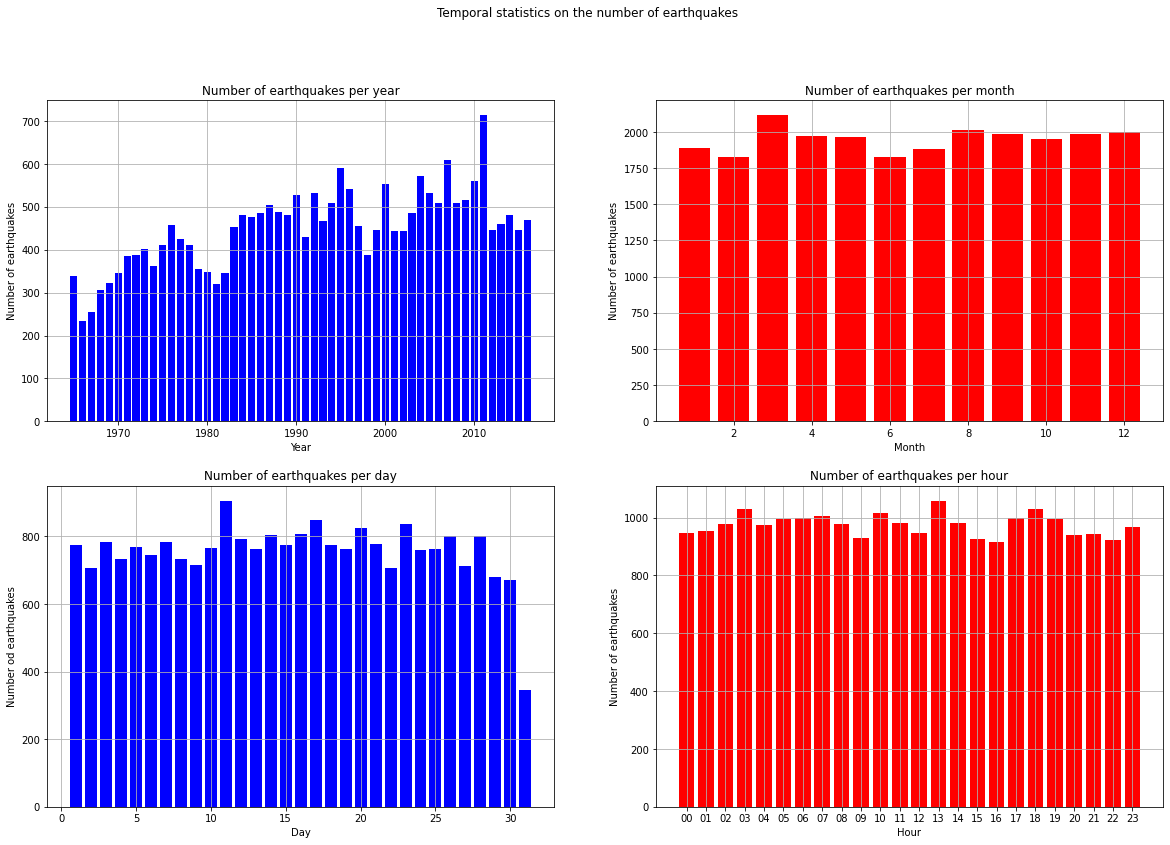

In [38]:
# Years, months, days, hours

# Years
df_year = df
df_year['year'] = df_year['Date'].map(lambda t: t.year)
df_year = df_year.groupby(['year'])['year'].count().reset_index(name='counts_year')

# Months
df_month = df
df_month['month'] = df_month['Date'].map(lambda t: t.month)
df_month = df_month.groupby(['month'])['month'].count().reset_index(name='counts_month')

# Days
df_day = df
df_day['day'] = df_day['Date'].map(lambda t: t.day)
df_day = df_day.groupby(['day'])['day'].count().reset_index(name='counts_day')

# Hours
df_hour = df
df_hour['Time'] = pd.to_datetime(df_hour['Time'], utc=True)
df_hour['hour'] = df_hour['Time'].map(lambda t: t.strftime('%H'))
df_hour = df_hour.groupby(['hour'])['hour'].count().reset_index(name='counts_hour')

fig, ax = plt.subplots(2, 2, figsize=(20,13))
fig.suptitle("Temporal statistics on the number of earthquakes")

# Earthquakes/year
ax[0,0].set_title("Number of earthquakes per year")
ax[0,0].bar(df_year['year'], df_year['counts_year'], color='blue')
ax[0,0].grid()
ax[0,0].set_xlabel("Year")
ax[0,0].set_ylabel("Number of earthquakes")

# Earthquakes/month
ax[0,1].set_title("Number of earthquakes per month")
ax[0,1].bar(df_month['month'], df_month['counts_month'], color='red')
ax[0,1].grid()
ax[0,1].set_xlabel("Month")
ax[0,1].set_ylabel("Number of earthquakes")

# Earthquakes/day
ax[1,0].set_title("Number of earthquakes per day")
ax[1,0].bar(df_day['day'], df_day['counts_day'], color='blue')
ax[1,0].grid()
ax[1,0].set_xlabel("Day")
ax[1,0].set_ylabel("Number od earthquakes")

# Earthquakes/hour
ax[1,1].set_title("Number of earthquakes per hour")
ax[1,1].bar(df_hour['hour'], df_hour['counts_hour'], color='red')
ax[1,1].grid()
ax[1,1].set_xlabel("Hour")
ax[1,1].set_ylabel("Number of earthquakes")
plt.show()

> Already from these graphs we can see that we do not have a correlation between time and number of earthquakes as all the data are fairly aligned, giving a uniform distribution. Instead, we can see how the number of earthquakes has increased over the years, perhaps indicating that, given the shifting of the tectonic plates, we are in a period where they are colliding more than a few years ago. Unfortunately, we cannot prove this, as we only have information relating to 50 years, too little to make hypotheses.
>
However, to underline the trend of the number of earthquakes, we provide a graph for the year with the minimum number of earthquakes, compared to that with the maximum number.

Text(0.5, 0, 'Year')

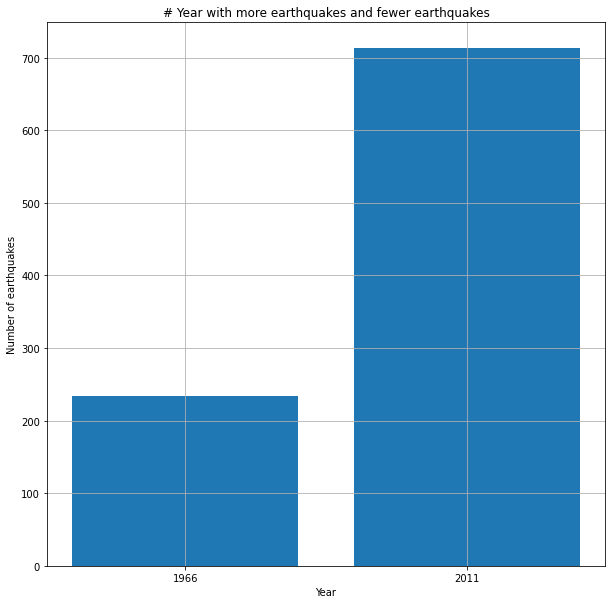

In [39]:
# Year with more earthquakes and fewer earthquakes
fig, ax = plt.subplots(figsize=(10,10))
yearMin = df_year['year'][df_year['counts_year'].argmin()]
yearMax = df_year['year'][df_year['counts_year'].argmax()]
plt.title("# Year with more earthquakes and fewer earthquakes")
ax.bar([str(yearMin), str(yearMax)], [df_year.min()['counts_year'], df_year.max()['counts_year']])
ax.grid()
ax.set_ylabel("Number of earthquakes")
ax.set_xlabel("Year")

We wonder, however, if there is any correlation in smaller time frames, such as hours and minutes.

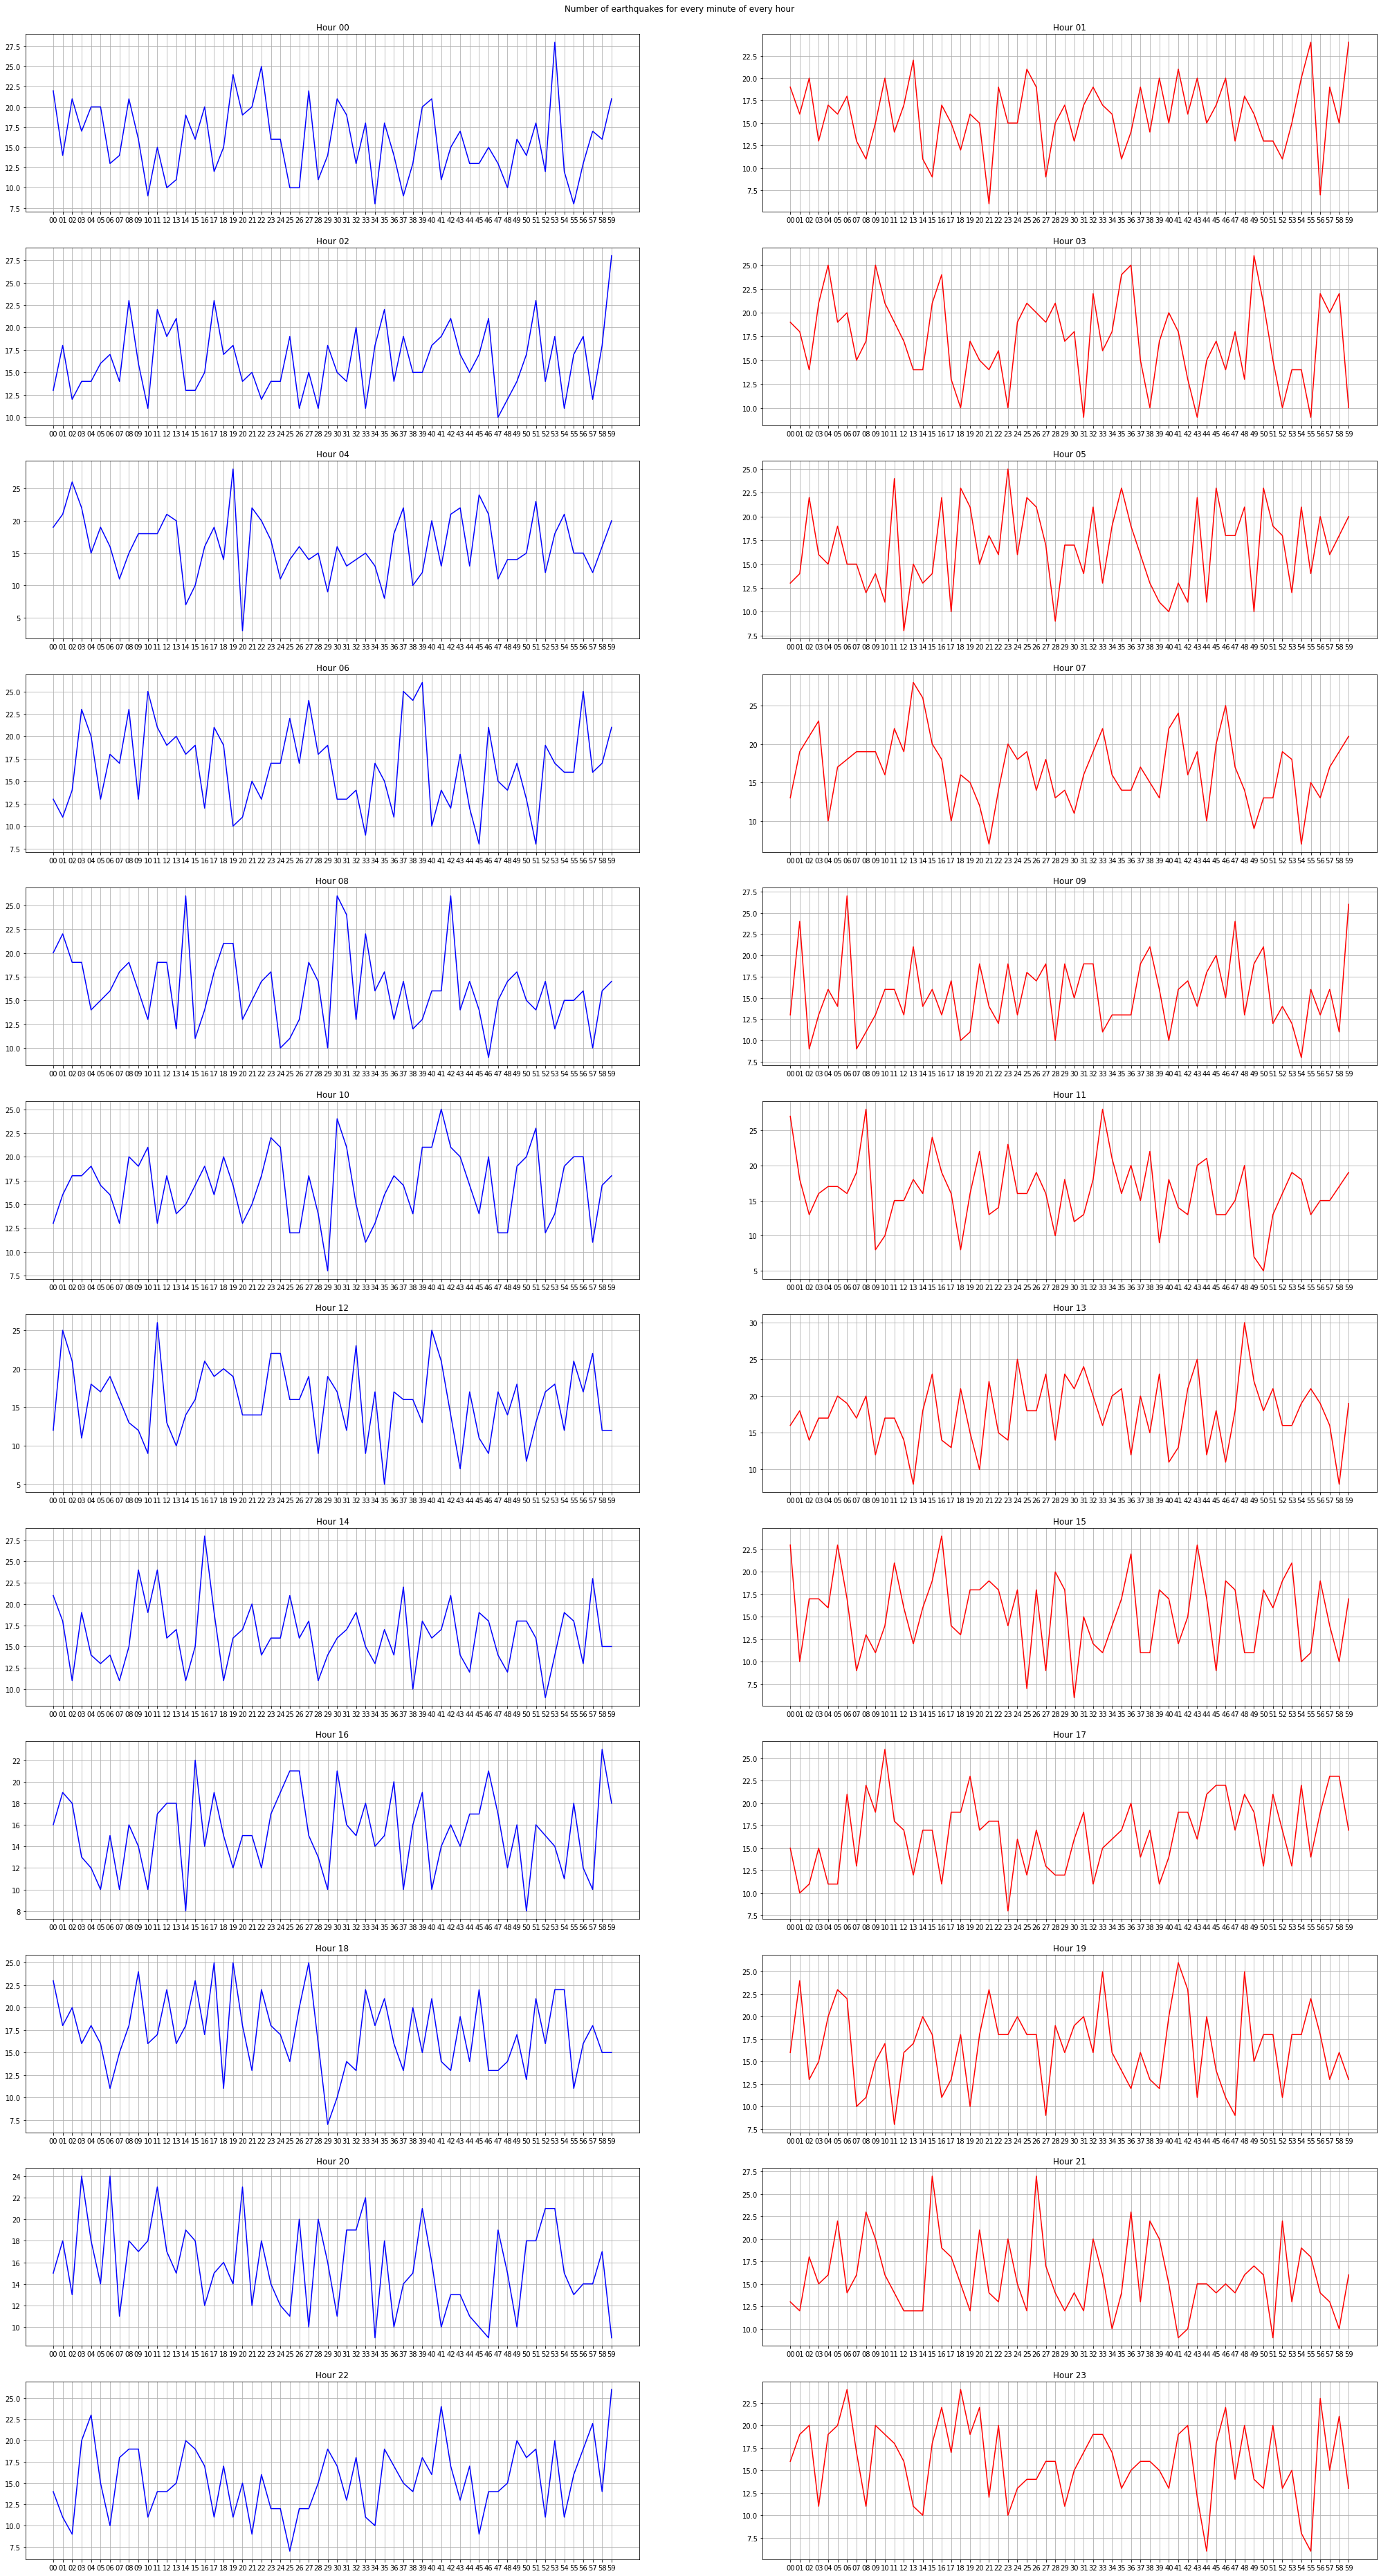

In [40]:
# Number of earthquakes per minute

# We prepare the data by separating the hours and minutes
df_hour = df
df_hour['Time'] = pd.to_datetime(df_hour['Time'], utc=True)
df_hour['Time'] = df_hour['Time'].map(lambda t: t.strftime('%H:%M'))

df_hour['hour'] = df_hour['Time'].map(lambda t: t[:2])
df_hour['minute'] = df_hour['Time'].map(lambda t: t[3:5])
df_hour = df_hour.groupby(['hour', 'minute'])['minute'].count().reset_index(name='counts_min')
hours = df_hour['hour'].unique()

# Charts
fig = plt.figure(1, figsize=(35,5*len(hours)//2))
fig.suptitle("Number of earthquakes for every minute of every hour")
fig.subplots_adjust(top=0.97)
for x in range(len(hours)//2):      # Print as many graphics as there are hours
    # Even time
    ax = fig.add_subplot(len(hours)//2, 2, 2*x+1)
    ax.set_title("Hour " + hours[2*x])
    ax.plot(df_hour[df_hour['hour'] == hours[2*x]]['minute'], df_hour[df_hour['hour'] == hours[2*x]]['counts_min'], '-b')
    ax.grid()
    # Odd time
    ax = fig.add_subplot(len(hours)//2, 2, 2*x+2)
    ax.set_title("Hour " + hours[2*x+1])
    ax.plot(df_hour[df_hour['hour'] == hours[2*x+1]]['minute'], df_hour[df_hour['hour'] == hours[2*x+1]]['counts_min'], '-r')
    ax.grid()

plt.show()



> As we can see, these data are linked to each other and, taking single hours or single minutes, we cannot make significant hypotheses.


## **Stronger earthquakes**

We now want to visualize the 10 strongest earthquakes recorded in the period under analysis.

In [41]:
# Stronger earthquakes
df_strong = df.sort_values('Magnitude', ascending=False)[['Date', 'Nation', 'Magnitude', 'Depth', 'Latitude', 'Longitude']][:10]
df_strong

,Date,Nation,Magnitude,Depth,Latitude,Longitude
20501,2011-03-11,JP,9.1,29.00,38.2970,142.3730
17083,2004-12-26,ID,9.1,30.00,3.2950,95.9820
19928,2010-02-27,CL,8.8,22.90,-36.1220,-72.8980
16,1965-02-04,RU,8.7,30.30,51.2510,178.7150
21219,2012-04-11,ID,8.6,20.00,2.3270,93.0630
17329,2005-03-28,ID,8.6,30.00,2.0850,97.1080
15440,2001-06-23,PE,8.4,33.00,-16.2650,-73.6410
18615,2007-09-12,ID,8.4,34.00,-4.4380,101.3670
21765,2013-05-24,RU,8.3,598.10,54.8920,153.2210
22791,2015-09-16,CL,8.3,22.44,-31.5729,-71.6744


As previously done, we make available a map where it is possible to zoom and view, using the mouse, the magnitude of each earthquake.

As already explained, we also use a heat map in this case, adapted to our purpose.

In [42]:
fig = px.density_mapbox(
                        df, lat=df_strong['Latitude'], lon=df_strong['Longitude'], z=df_strong['Magnitude'],
                        mapbox_style="dark", labels = {'z' : 'Magnitude', 'lat' : 'Latitude', 'lon' : 'Longiture'},
                        zoom=1.3, radius = 25, width = 1500, height = 900, center=dict(lat=30, lon=15),
                        range_color=(1,10),
                        color_continuous_scale=px.colors.sequential.Jet_r    
                        )
fig.update_layout(title_text='Map of the 10 strongest earthquakes', title_font=dict(size=32), mapbox_accesstoken = "pk.eyJ1IjoiY2Fzc2FwYW5jYTk5IiwiYSI6ImNrcHlrZ3hubjA3NHMycW84ZnFhcTFnYzgifQ.HscwNQouRsZW52ELwpuR_A")

fig.show()

## **Depth data**

Let's try to look at the data relating to the depth of earthquakes. Starting with the visualization of the 10 deepest earthquakes.

In [43]:
# Deeper earthquakes
df_depth = df.sort_values('Depth', ascending=False)[['Date', 'Nation', 'Depth', 'Magnitude', 'Latitude', 'Longitude']][:10]
df_depth

,Date,Nation,Depth,Magnitude,Latitude,Longitude
7734,1985-10-22,TO,700.0,5.5,-20.158,-179.163
15933,2002-08-19,FJ,691.6,5.6,-24.871,178.566
4361,1977-06-17,TO,690.0,5.7,-19.876,-179.098
18436,2007-05-06,TO,688.0,6.1,-19.406,-179.315
14999,2000-09-02,TO,687.6,6.0,-20.073,-179.135
18437,2007-05-07,TO,682.2,5.6,-19.251,-179.362
13887,1998-02-09,RU,678.9,5.5,51.550,149.639
15931,2002-08-19,FJ,677.4,6.1,-23.899,178.375
18435,2007-05-06,TO,676.4,6.5,-19.401,-179.354
7218,1984-10-10,TO,675.6,5.6,-20.147,-179.271


In [44]:
fig = px.density_mapbox(
                        df, lat=df_depth['Latitude'], lon=df_depth['Longitude'], z=df_depth['Depth'],
                        mapbox_style="dark", labels = {'z' : 'Depth', 'lat' : 'Latitude', 'lon' : 'Longiture'} ,
                        zoom=1.3, radius = 25, width = 1500, height = 900,
                        range_color=(0, max(df_depth['Depth'])),
                        color_continuous_scale=px.colors.sequential.Jet_r    # https://plotly.com/python/builtin-colorscales/
                        )
fig.update_layout(title_text='Map of the 10 deepest earthquakes', title_font=dict(size=32), mapbox_accesstoken = "pk.eyJ1IjoiY2Fzc2FwYW5jYTk5IiwiYSI6ImNrcHlrZ3hubjA3NHMycW84ZnFhcTFnYzgifQ.HscwNQouRsZW52ELwpuR_A")

fig.show()

> We can see that most of the deepest earthquakes ever recorded are located near the Fiji Islands. Place where, given the graphs relating to the tectonic plates, two different plates collide.

We now want to check if there is a correlation between depth and magnitude and which are the states with the average of the greatest depth.

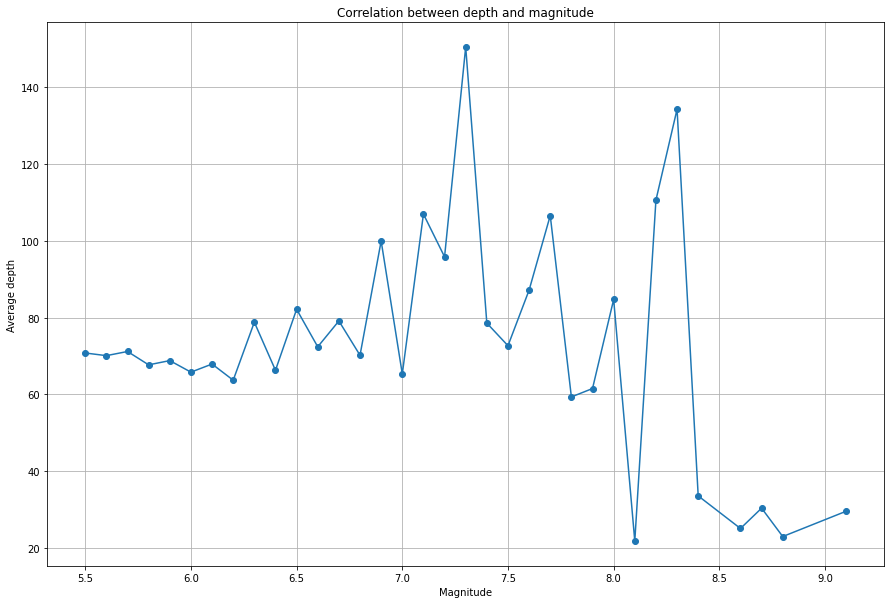

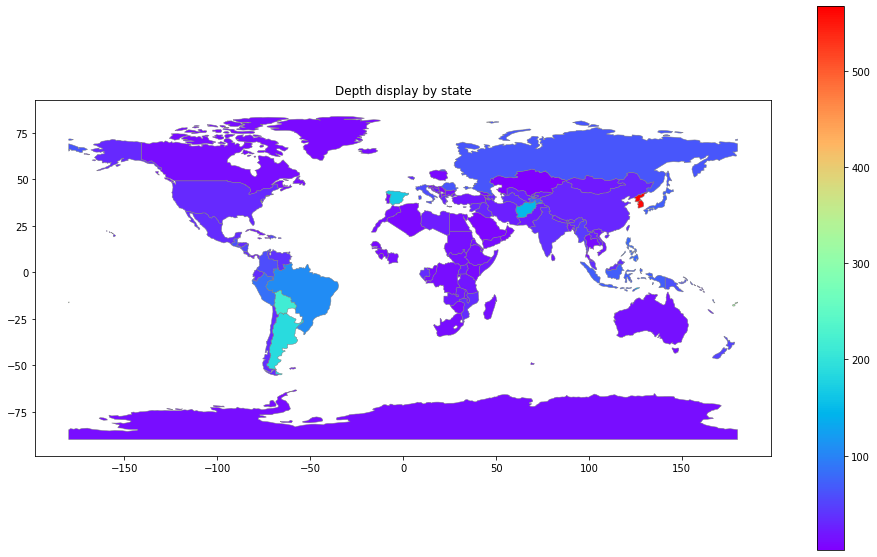

In [45]:
# Correlation between depth and magnitude
df_avgDepth = df.groupby('Magnitude')['Depth'].mean('Depth').reset_index(name='Depth')
fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Correlation between depth and magnitude')
ax.set_xlabel("Magnitude")
ax.set_ylabel("Average depth")
ax.plot(df_avgDepth['Magnitude'], df_avgDepth['Depth'], marker='o')
ax.grid()

# States with depth

# Group by nation alpha 2
df_tmp = df.groupby('Nation')['Depth'].mean('Depth').reset_index(name='Depth')

# Convert iso alpha 2 --> iso alpha 3
for i in range(len(df_tmp)):    
    if df_tmp['Nation'][i] != 'XK':     # Kosovo not present in geopandas, identified as Serbia
        # I replace alpha 2 values in alpha 3
        df_tmp['Nation'].replace(df_tmp['Nation'][i], (pd.Series([pc.country_name_to_country_alpha3(pc.country_alpha2_to_country_name(df_tmp['Nation'][i]))]))[0], inplace=True)

# Merge with the geopandas dataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(df_tmp, left_on='iso_a3', right_on='Nation', how='left').dropna(axis=0).reset_index()

# Graphic
world.plot(column='Depth', cmap='rainbow', legend=True, linewidth=0.5, edgecolor='0.5', figsize=(16.48, 10))
plt.title("Depth display by state")
plt.show()

> We can see that there is no particular trend in the curve that represents the correlation between depth and magnitude. We can only note that the most powerful earthquakes occur at very shallow depths, while the weakest ones are around 70 meters deep.
>
> We can see that the state with the highest average depth is Korea, to which only one earthquake of those visible in the top 10 depth belongs, but still maintains an average of more than 500 meters. This probably because it has earthquakes with constant depth and because, having a modest surface, it has few earthquakes recorded in its name. This can be seen in the graph for the number of earthquakes by state, where you can see that most of the earthquakes detected in that area are attributed to Japan. Despite this observation, we can have a very precise clue as to the depth at which the tectonic plates corresponding to Korea are colliding.

## **Data extracted from the dataset**

Now let's try to extrapolate other data from the dataset looking for interesting information present, but not yet found.

Let's start by looking for a correlation between the mean of the magnitude and the number of earthquakes

Text(0, 0.5, 'Number of earthquakes')

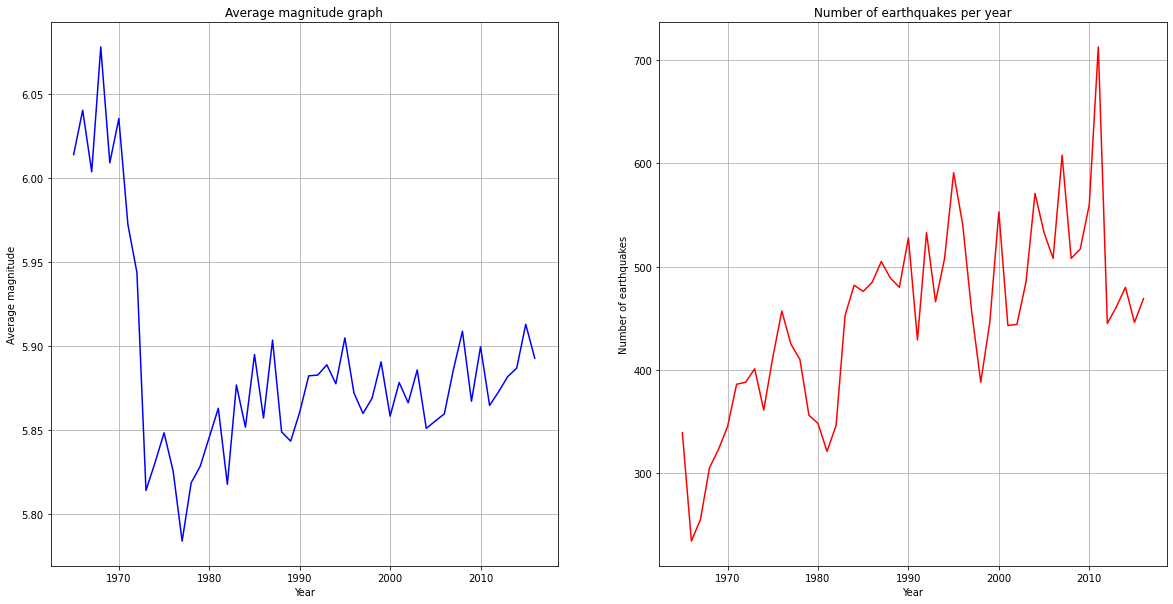

In [46]:
# How many earthquakes per year on average and average magnitude
df_date = df[['Date', 'Magnitude']]
df_date['Date'] = pd.DatetimeIndex(df['Date']).year
df_avg = df_date.groupby("Date").mean()     # Annual average magnitude
df_date = df_date.groupby("Date")['Date'].count().reset_index(name='counts')    # Num earthquakes per year

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(df_avg, '-b')    # Annual average magnitude graph
ax1.set_title("Average magnitude graph")
ax1.grid()
ax1.set_xlabel("Year")
ax1.set_ylabel("Average magnitude")
ax2.plot(df_date['Date'], df_date['counts'], '-r')   # Chart num earthquakes per year
ax2.set_title("Number of earthquakes per year")
ax2.grid()
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of earthquakes")

> Seeing this result we could be convinced of the fact that a greater number of earthquakes correspond to a lower average magnitude and vice versa. This is demonstrated by the graph, but it does not correspond to an absolute truth. This is because the magnitude is a logarithmic scale and therefore having values with high magnitude is very unlikely and therefore even if we had some earthquakes of very high magnitude, its annual average would be lowered by the rest of the earthquakes. This does not allow us to extrapolate correct data as the average of the magnitudes will always tend to the most probable value, eliminating the possibility of noticing earthquakes with a higher magnitude.

To prove this we calculate the frequency of the magnitudes.

In [47]:
# Frequency magnitude
over_time = []
# For each magnitude between i and i + 1 we go to count how many earthquakes have occurred and we calculate the annual average
for i in range(int(min(df_avg['Magnitude'].round(1))), 10):
    over_time.append((i, (df[(df['Magnitude'] >= i) & (df['Magnitude'] < i+1)]['Magnitude'].count())/(max(pd.DatetimeIndex(df['Date']).year) - min(pd.DatetimeIndex(df['Date']).year))))

# Print of the frequency of earthquakes
for i in over_time:
    print("\033[1mMagnitude", i[0], end='\033[0m')
    if i[1] < 1:    # If less than one earthquake a year
        print(": approximately 1 every", 1/i[1], "years")
    else:
        print(": approximately", i[1], "every year")


Magnitude 5: approximately 314.84313725490193 every year
Magnitude 6: approximately 129.7450980392157 every year
Magnitude 7: approximately 13.686274509803921 every year
Magnitude 8: approximately 1 every 1.3421052631578947 years
Magnitude 9: approximately 1 every 25.5 years


> As already explained, this data confirms that the average will always tend to magnitude 5-6

Let's see if we can extrapolate information about the type of magnitude, the frequency of each type and the depth at which a type search is recorded.

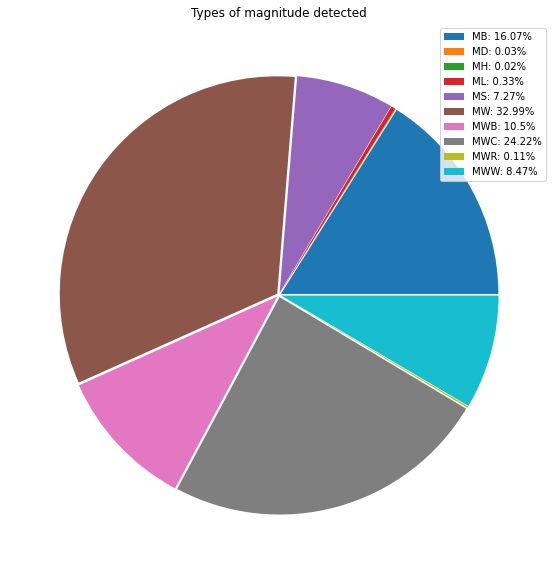

In [48]:
# Magnitude type analysis
plt.figure(figsize=(10,10))
plt.title("Types of magnitude detected")
df_magType = df.groupby('Magnitude Type')['Magnitude Type'].count().reset_index(name='counts')
plt.pie(df_magType['counts'], explode = np.ones(len(df_magType['counts'])) * 0.01)
percent = 100/sum(df_magType['counts'])
labels = [f'{l}: {s}%' for l, s in zip(df_magType['Magnitude Type'], round(df_magType['counts']*percent, 2))]
plt.legend(labels)
plt.show()

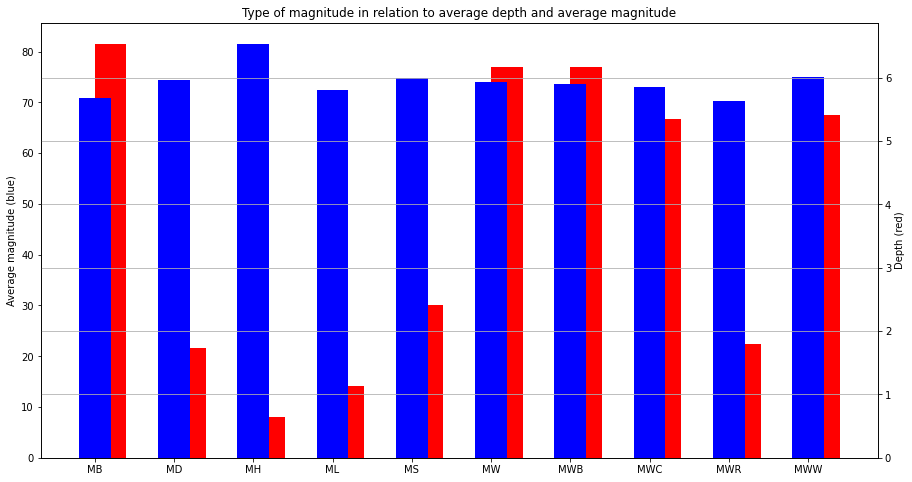

In [49]:
# Type of magnitude in relation to average depth and average magnitude
df_magTypeDepth = df.groupby('Magnitude Type')['Depth'].mean('Depth').reset_index(name='avg_depth')[['Magnitude Type', 'avg_depth']]
df_magTypeMag = df.groupby('Magnitude Type')['Magnitude'].mean('Magnitude').reset_index(name='avg_magnitude')[['Magnitude Type', 'avg_magnitude']]

fig = plt.figure(figsize=(15,8)) # Create matplotlib figure
ax = fig.add_subplot() # Create matplotlib axes
ax2 = ax.twinx() # Creation of the second axis

ax.bar(df_magTypeDepth['Magnitude Type'], df_magTypeDepth['avg_depth'], color='red', align='edge', width=0.4)
ax2.bar(df_magTypeDepth['Magnitude Type'], df_magTypeMag['avg_magnitude'], color='blue', align='center', width=0.4)

ax.set_ylabel('Average magnitude (blue)')
ax2.set_ylabel('Depth (red)')
plt.title("Type of magnitude in relation to average depth and average magnitude")
plt.grid()
plt.show()

> This graph summarizes the information regarding the type of magnitude, the average value and the depth. This information allows an in-depth analysis of earthquakes, but we do not consider it appropriate to go into excessively complex explanations that are not within our competence. For further information, please refer to the link below.
>
>
>https://www.usgs.gov/natural-hazards/earthquake-hazards/science/magnitude-types?qt-science_center_objects=0#qt-science_center_objects


Finally, we ask ourselves which structure has managed to detect the greatest number of earthquakes.

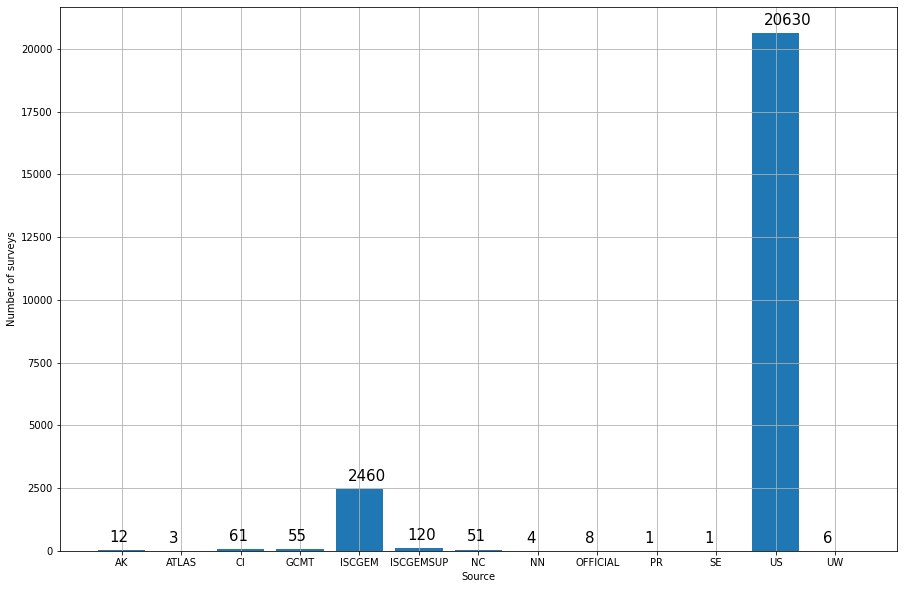

In [50]:
# Stations with number of surveys carried out
df_source = df.groupby('Source')['Source'].count().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(df_source['Source'], df_source['counts'])
ax.grid()
ax.set_ylabel("Number of surveys")
ax.set_xlabel("Source")
for v, i in enumerate(df_source['counts']):
    ax.text(v-0.2, i+500, ""+str(df_source['counts'][v]), va='center', fontsize=15)

## **Prediction**


For predictive analysis we used the Sklearn library taking inspiration from the following work: https://www.kaggle.com/mahadevmm9/earthquake-prediction
The model below creates a predictive tree trained on the data present in the dataset, looking for a correlation between latitude and longitude with magnitude and depth. Once trained, we subjected it to tests to calculate its correctness and verify its reliability. As a final testimony we tried to have the depth and magnitude of a future earthquake predicted in the same coordinates as the deeper earthquake present in the dataset. The result meets expectations by giving a high depth and a magnitude consistent with the analyzed data.

In [51]:
# https://scikit-learn.org/stable/
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from mpl_toolkits.basemap import Basemap


# Data standardization
data = df[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
x,y = m(longitudes,latitudes)

X = data[['Latitude', 'Longitude']]
y = data[['Magnitude', 'Depth']]

# Split the data to get the test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
print("Elements we train on:", len(X_train), "\nElements we test on:", len(X_test))

# Decision tree, data fit and prediction
reg = RandomForestRegressor(random_state=42)    # The random_state field is used to add a slight randomness to the tree since, being a greedy algorithm, it does not always lead to the best result
reg.fit(X_train, y_train)
reg.predict(X_test)

print("Accuracy", reg.score(X_test, y_test)*100, "%")

Elements we train on: 23177 
Elements we test on: 235
Accuracy 88.2962918580128 %


In [52]:
predict_latitude = 3.2950
predict_longitude = 95.9820
predict_input = pd.DataFrame(data={'Latitude': [predict_latitude], 'Longitude':[predict_longitude]})
predict_result = reg.predict(predict_input)[0]
print("Earthquake predicted in ( lat:", predict_latitude, "- lon:", predict_longitude, ")\nMagnitude:", predict_result[0], "- Depth:", predict_result[1])

Earthquake predicted in ( lat: 3.295 - lon: 95.982 )
Magnitude: 8.20900000000001 - Depth: 29.779


#**Conclusion**
> In the above results we showed how we managed to realize our idea by centering what we wanted to point out in terms of information, i.e. where most earthquakes occur and with what intensity, trying to graphically deduce where the faults are located in our planet and any correlations storms or with other data, such as depth.